In [2]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import tqdm
import copy
import pandas as pd
import statistics
import datetime

In [83]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, reduced_prob: float ,mitigation_proportion: float, sicknode = 0, SW_connections = 3, edge_randomness = 0.2, SF_k = 1, plots = False, TTR = 15):
        '''
        sicknodes - number of sick nodes to begin with
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = edge_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = edge_randomness, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        # self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.p_reduced = reduced_prob # reduced probability of infection due to mitigation
        self.mit_prop = mitigation_proportion # proporation of the population that follows the mitigation
        self.want_plots = plots
        self.masked = []
        self.sicknodes = [random.randint(0, nodes-1) for i in range(sicknode)] # randomly generate n number of sicknnodes
        # print(self.sicknodes)
        # if not sicknode:
        #     self.sicknodes = set([])
        # else:
        #     self.sicknodes = set([sicknode])
        self.recovered = []
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model

        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
    
    def plot(self):

        node_colors = ["green" if node in self.recovered else 'magenta' if node in self.masked else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p_reduced]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible

        plt.title("Small Worlds Graph: Nodes = "+ str(self.n)+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []

        for time in tqdm.tqdm(range(steps)):
            #check sick nodes
            new_sick = 0
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                cumulative_case_count.append(len(self.sicknodes))

                # initialise edge weights
                for i in self.sicknodes:
                    if np.random.random() < self.mit_prop: # a proportion of initially sick nodes will adopt mitigation measures
                        self.masked.append(i)
                    else: 
                        pass
                edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                for j in edge_list:
                    if (j[0] in self.masked or j[1] in self.masked)  :
                        self.g.add_edge(j[0], j[1], weight = self.p_reduced) 
                    elif (j[0] in self.sicknodes or j[1] in self.sicknodes) and (j[0] not in self.masked or j[1] not in self.masked):
                        self.g.add_edge(j[0], j[1], weight = self.p) 
                    else:
                        self.g.add_edge(j[0], j[1], weight = 0) 

                # self.plot()
                
            else: 
                pass
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            
            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones
            #print("sicknodes:", currentsick)

            for i in range(len(list(self.g.nodes))):
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    neighbours = list(self.g.neighbors(i))
                    for n in neighbours:
                        if n in self.sicknodes:
                            pass
                        else:
                            self.g.add_edge(i, n, weight = 0)

                    if i in self.masked:
                        self.masked.remove(i)
                    else:
                        pass
                    self.recovered.append(i)
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
            
            for node in currentsick:
                neighbours = list(self.g.neighbors(node))

                #try to propagate sickness
                for neighbour in neighbours:
                    if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick or recovered.
                        pass
                    elif np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                        self.sicknodes.append(neighbour)
                        adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                        new_sick += 1

                        nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                        if np.random.random() < self.mit_prop: # determine whether newly sick node will adopt mitigation measure
                            self.masked.append(neighbour)
                            for i in adj_neighbours:
                                self.g.add_edge(i, neighbour, weight = self.p_reduced) # mitigated probability of infection -> overwrite all edges

                        else: # node did not adopt mitigation measure 
                            for i in adj_neighbours: 
                                if self.g.get_edge_data(i,neighbour)['weight'] == self.p_reduced: # do not overwrite mitigated edges
                                    pass
                                else: 
                                    self.g.add_edge(i, neighbour, weight = self.p) # non-mitigated probability of infection.

                    else: # node not infected
                        pass
            
            cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
                
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1]

In [5]:
n_nodes = 10000
n_type = 'Small World'
inf_prob = 0.8
red_prob = 0.1
mitigation_prop = 0
SW_con = 3
randomness = 0.5
TTR_days = 10
prop_timestep = 500

param_values = [i/20 for i in range(20)]
path_lengths = []
time_to_propagate = []
avg_degree = []
subgraphs = []
max_clique_size = []
infected_percentage = []

for param in tqdm.tqdm(param_values):
    G = Pandemic_Network(nodes = n_nodes, network_type = n_type, pandemicprob = inf_prob, reduced_prob = red_prob, mitigation_proportion = mitigation_prop, sicknode = 1, SW_connections = SW_con, edge_randomness = param, plots = False, TTR = TTR_days)
    
    # SHORTEST PATH LENGTH
    count = 0
    ind_path_lengths = []
    for C in (G.g.subgraph(c).copy() for c in nx.connected_components(G.g)):
        count += 1
        ind_path_lengths.append(nx.average_shortest_path_length(C))
        # print(nx.average_shortest_path_length(C))
    subgraphs.append(count)
    # print('Number of subgraphs: ', count)
    path_lengths.append(statistics.mean(ind_path_lengths))
    # print('Average shortest path length: ', statistics.mean(ind_path_lengths))

    # AVERAGE DEGREE
    avg_degree.append(sum([G.g.degree[i] for i in range(len(G.g.nodes))])/len(G.g.nodes)) 

    # CLIQUE
    cliques = list(nx.find_cliques_recursive(G.g))
    max_clique = 0
    for i in range(len(cliques)): # iterate through each clique
        if len(cliques[i]) >= max_clique:
            max_clique = len(cliques[i])
        else:
            pass
    max_clique_size.append(max_clique)

    # PROPAGATION
    G_data = G.propagate(prop_timestep)
    final_inf = G_data[-1][-1] # final number of total infected individuals
    time = 0
    while G_data[-1][time] < final_inf:
        time += 1
    time_to_propagate.append(time) # time it takes to infect the entire population

    infected_percentage.append(final_inf/n_nodes) # infected proportion
        

  0%|          | 0/20 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [63]:
results_df = pd.DataFrame(data = [param_values, path_lengths, time_to_propagate, avg_degree, subgraphs, max_clique_size, infected_percentage]).transpose()
results_df.columns = ['Parameter Value (Randomness of SW diagram)', 'Average Path Length', 'Propagation Time', 'Average Degree of a Node', 'Number of Subgraphs', 'Maximum Clique Size', 'Percentage of Population Infected']
date = datetime.date.today()
results_df.to_csv('Percolation Results - Randomness {}.csv'. format(date))

In [53]:
n_nodes = 2000
n_type = 'Small World'
inf_prob = 0.8
red_prob = 0.1
mitigation_prop = 0
SW_con = 3
randomness = 0.5
TTR_days = 10
prop_timestep = 100

G = Pandemic_Network(nodes = n_nodes, network_type = n_type, pandemicprob = inf_prob, reduced_prob = red_prob, mitigation_proportion = mitigation_prop, sicknode = 1, SW_connections = SW_con, edge_randomness = randomness, plots = False, TTR = TTR_days)
# subgraphs_list = (G.g.subgraph(c).copy() for c in nx.connected_components(G.g))
# # subgraphs.append(len(list(subgraphs)))
count = 0
ind_path_lengths = []
for C in (G.g.subgraph(c).copy() for c in nx.connected_components(G.g)):
    count += 1
    ind_path_lengths.append(nx.average_shortest_path_length(C))
    print(nx.average_shortest_path_length(C))
# subgraphs.append(count)
print('Number of subgraphs: ', count)
# path_lengths.append(statistics.mean(ind_path_lengths))
print('Average shortest path length: ', statistics.mean(ind_path_lengths))

40.42948315547186
30.44746482984064
32.609900110987795
Number of subgraphs:  3
Average shortest path length:  34.495616032100095


## Amended Pandemic Network class for Percolation

In [17]:
def find_dims(nodes):
    n = int(np.sqrt(nodes))
    if (nodes == n**2) == False: # nodes is not a perfect square
        factors = []
        for i in range(1, nodes + 1):
            if nodes % i == 0:
                factors.append(i)
                
        mul1 = min([i for i in factors if i > n])
        dim = (mul1, int(nodes / mul1))
    else: 
        dim = (n,n)
    return dim


class Pandemic_Network():
    
    def __init__(self, nodes: int, network_type: str, pandemicprob: float, reduced_prob: float ,mitigation_proportion: float, sicknode = 0, SW_connections = 2, edge_randomness = 0.2, SF_k = 1, plots = False, TTR = 15):

        # self.g = nx.grid_graph(dim = dim)
        self.type = network_type

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = edge_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = edge_randomness, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        dim = find_dims(nodes)
        mapping = {i:(int(i/dim[1]),i%dim[1]) for i in self.g.nodes()}
        self.g = nx.relabel_nodes(self.g, mapping)

        # self.pos = nx.circular_layout(self.g)
        self.pos = {(x,y):(y,-x) for x,y in self.g.nodes()}
        self.n = nodes
        self.t = 0
        self.k = SW_connections
        self.randomness = edge_randomness
        self.p = pandemicprob
        self.p_reduced = reduced_prob # reduced probability of infection due to mitigation
        self.mit_prop = mitigation_proportion # proporation of the population that follows the mitigation
        self.want_plots = plots
        self.masked = []
        self.nodes_list = [(i,j) for (i,j) in self.g.nodes]

        self.sicknodes = [(random.randint(0, dim[0]-1), random.randint(0, dim[1]-1)) for i in range(sicknode)]
        # print(self.sicknodes)
        # if not sicknode:
        #     self.sicknodes = set([])
        # else:
        #     self.sicknodes = set([sicknode])
        self.recovered = []
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model

        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in self.nodes_list]
        initial_TTR_dict = {self.nodes_list[i]:initial_TTR_vals[i] for i in range(len(self.nodes_list))}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
    
    
    def plot(self):
        plt.figure(figsize=(10,10))

        # nx.draw(self.g, pos=self.pos, 
        # with_labels=False,
        # font_size = 10,
        # node_size=100)

        node_colors = ["green" if node in self.recovered else 'magenta' if node in self.masked else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=50000/self.n, node_color=node_colors, linewidths=0, width = 0)

        # DRAW EDGES
        # e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        # e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p_reduced]
        # e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        # nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=1, edge_color='red') # un-masked
        # nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=1, edge_color='orange') # masked
        # nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=1, edge_color='lime') # susceptible

        plt.title("Nodes = "+ str(self.n)+ ", Time = " + str(self.t) + ", Network Type = " + str(self.type) + ", \n p = " + str(self.p) + ", Avg Connections = " + str(self.k)+ ", Edge Randomness = " + str(self.randomness))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []

        for time in tqdm.tqdm(range(steps)):
            #check sick nodes
            new_sick = 0
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                
                cumulative_case_count.append(len(self.sicknodes))

                # initialise edge weights
                for i in self.sicknodes:
                    if np.random.random() < self.mit_prop: # a proportion of initially sick nodes will adopt mitigation measures
                        self.masked.append(i)
                    else: 
                        pass
                edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                for j in edge_list:
                    if (j[0] in self.masked or j[1] in self.masked)  :
                        self.g.add_edge(j[0], j[1], weight = self.p_reduced) 
                    elif (j[0] in self.sicknodes or j[1] in self.sicknodes) and (j[0] not in self.masked or j[1] not in self.masked):
                        self.g.add_edge(j[0], j[1], weight = self.p) 
                    else:
                        self.g.add_edge(j[0], j[1], weight = 0) 
                # self.plot()

            else: 
                pass
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            
            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones
            #print("sicknodes:", currentsick)


            for i in self.nodes_list:
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    neighbours = [(i,j) for (i,j) in self.g.neighbors(i)]
                    for n in neighbours:
                        if n in self.sicknodes:
                            pass
                        else:
                            self.g.add_edge(i, n, weight = 0)

                    if i in self.masked:
                        self.masked.remove(i)
                    else:
                        pass
                    self.recovered.append(i)
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
            for node in currentsick:
                neighbours = [(i,j) for (i,j) in self.g.neighbors(node)]

                #try to propagate sickness
                for neighbour in neighbours:
                    if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick or recovered.
                        pass
                    elif np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                        self.sicknodes.append(neighbour)
                        adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                        new_sick += 1

                        nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                        if np.random.random() < self.mit_prop: # determine whether newly sick node will adopt mitigation measure
                            self.masked.append(neighbour)
                            for i in adj_neighbours:
                                self.g.add_edge(i, neighbour, weight = self.p_reduced) # mitigated probability of infection -> overwrite all edges

                        else: # node did not adopt mitigation measure 
                            for i in adj_neighbours: 
                                if self.g.get_edge_data(i,neighbour)['weight'] == self.p_reduced: # do not overwrite mitigated edges
                                    pass
                                else: 
                                    self.g.add_edge(i, neighbour, weight = self.p) # non-mitigated probability of infection.

                    else: # node not infected
                        pass
            
            cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
        # self.plot()
                
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1]

In [202]:
SW_connections = [2,3,4,5,6]
randomness = [i/40 for i in range(1,40)]

size_subgraphs = []
num_subgraphs = []
connections = []
r_val = []

for con in tqdm.tqdm(SW_connections):
    for r in tqdm.tqdm(randomness):

        r_val.append(r)
        connections.append(con)

        G = Pandemic_Network(nodes = 50000, network_type='Small World', pandemicprob = 0.4, sicknode = 1, SW_connections = con, edge_randomness = r, reduced_prob = 0.1, mitigation_proportion = 0, plots = False)
        connected = list(nx.connected_components(G.g))
        num_subgraphs.append(len(connected))
        size_subgraphs.append([len(i) for i in connected])

100%|██████████| 5/5 [04:04<00:00, 48.89s/it]


In [210]:
df = pd.DataFrame([r_val, connections, num_subgraphs, size_subgraphs]).transpose()
df.columns = ['Randomness', 'Average Connections','Number of Subgraphs', 'Size of Subgraphs']
df

,Randomness,Average Connections,Number of Subgraphs,Size of Subgraphs
0,0.025,2,4,"[46886, 2680, 378, 56]"
1,0.05,2,6,"[23870, 10126, 4792, 10931, 52, 229]"
2,0.075,2,4,"[16655, 21918, 9119, 2308]"
3,0.1,2,5,"[45897, 473, 2710, 347, 573]"
4,0.125,2,2,"[29779, 20221]"
...,...,...,...,...
190,0.875,6,1,[50000]
191,0.9,6,1,[50000]
192,0.925,6,1,[50000]
193,0.95,6,1,[50000]


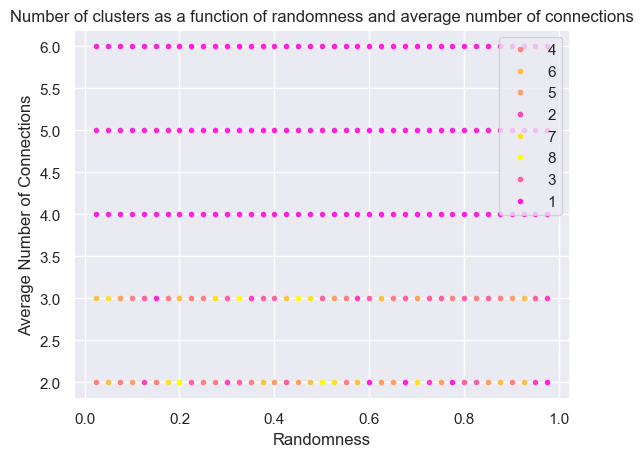

In [226]:
unique_val = []
for i in range(len(num_subgraphs)):
    if num_subgraphs[i] not in unique_val:
        unique_val.append(num_subgraphs[i])
        plt.plot(r_val[i],connections[i],'.', color = cm.spring(num_subgraphs[i]/max(num_subgraphs)), label = '{}'.format(num_subgraphs[i]))
    else:
        plt.plot(r_val[i],connections[i],'.', color = cm.spring(num_subgraphs[i]/max(num_subgraphs)))
plt.xlabel('Randomness')
plt.ylabel('Average Number of Connections')
plt.title('Number of clusters as a function of randomness and average number of connections')
plt.legend()
plt.show()

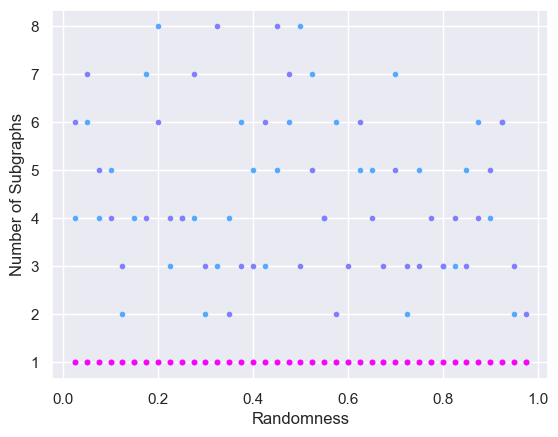

In [230]:
for i in range(len(num_subgraphs)):
    plt.plot(r_val[i], num_subgraphs[i],'.', color = cm.cool(connections[i]/max(connections)))

plt.xlabel('Randomness')
plt.ylabel('Number of Subgraphs')
plt.show()

In [126]:
n_nodes = 20000
n_type = 'Small World'
inf_prob = 0.5
red_prob = 0.1
mitigation_prop = 0
TTR_days = 10
prop_timestep = 500
randomness = 0.2

probabilities = [i/20 for i in range(1,20)]
connections = [2,3,4,5,6]
# mitigations = [i/20 for i in range(1,20)]
mitigations = [0]


path_lengths = []
time_to_propagate = []
avg_degree = []
subgraphs = []
max_clique_size = []
infected_percentage = []
r_values = []
c_values = []
m_values = []

for c_val in tqdm.tqdm(connections):
                
                c_values.append(c_val)

                G = Pandemic_Network(nodes = n_nodes, network_type = n_type, pandemicprob = inf_prob, reduced_prob = red_prob, mitigation_proportion = mitigation_prop , sicknode = 1, SW_connections = c_val, edge_randomness = randomness, plots = False, TTR = TTR_days)
                
                # SHORTEST PATH LENGTH
                count = 0
                ind_path_lengths = []
                for C in (G.g.subgraph(c).copy() for c in nx.connected_components(G.g)):
                    count += 1
                    ind_path_lengths.append(nx.average_shortest_path_length(C))
                    # print(nx.average_shortest_path_length(C))
                subgraphs.append(count)
                # print('Number of subgraphs: ', count)
                path_lengths.append(statistics.mean(ind_path_lengths))
                # print('Average shortest path length: ', statistics.mean(ind_path_lengths))

                # AVERAGE DEGREE
                avg_degree.append(sum([G.g.degree[i] for i in range(len(G.g.nodes))])/len(G.g.nodes)) 

                # CLIQUE
                cliques = list(nx.find_cliques_recursive(G.g))
                max_clique = 0
                for i in range(len(cliques)): # iterate through each clique
                    if len(cliques[i]) >= max_clique:
                        max_clique = len(cliques[i])
                    else:
                        pass
                max_clique_size.append(max_clique)

                # PROPAGATION
                G_data = G.propagate(prop_timestep)
                final_inf = G_data[-1][-1] # final number of total infected individuals
                time = 0
                while G_data[-1][time] < final_inf:
                    time += 1
                time_to_propagate.append(time) # time it takes to infect the entire population

                infected_percentage.append(final_inf/n_nodes) # infected proportion
                

  0%|          | 0/5 [04:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
path_lengths = []
time_to_propagate = []
avg_degree = []
subgraphs = []
max_clique_size = []
infected_percentage = []
r_values = []
c_values = []
m_values = []

results_df = pd.DataFrame(data = [r_values, c_values, m_values, infected_percentage, max_clique_size, subgraphs, avg_degree, time_to_propagate, path_lengths]).transpose()
results_df.columns = ['Randomness', 'Connections', 'Proportion of Population Adopting Mitigation', 'Percentage of Population Infected','Maximum Clique Size','Number of Subgraphs','Average Degree', 'Time to Propagate Disease','Average Path Lengths']
date = datetime.date.today()
results_df.to_csv('Percolation Results {}.csv'. format(date))

## Site Percolation Analysis

In [1]:
def find_dims(nodes):
    n = int(np.sqrt(nodes))
    if (nodes == n**2) == False: # nodes is not a perfect square
        factors = []
        for i in range(1, nodes + 1):
            if nodes % i == 0:
                factors.append(i)
                
        mul1 = min([i for i in factors if i > n])
        dim = (mul1, int(nodes / mul1))
    else: 
        dim = (n,n)
    return dim


class Pandemic_Network():
    
    def __init__(self, p_edge_removal: float, nodes: int, network_type: str, pandemicprob: float, reduced_prob: float ,mitigation_proportion: float, sicknode = 0, SW_connections = 2, edge_randomness = 0.2, SF_k = 1, plots = False, TTR = 15):
        
        dim = find_dims(nodes)
        self.g = nx.grid_graph(dim = dim)
        # self.type = network_type

        # if network_type == 'Ring': # default is a ring network
        #     self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        # elif network_type == 'Small World':
        #     self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = edge_randomness, seed=None)
        # elif network_type == 'Scale Free':
        #     self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        # else:
        #     self.g = nx.erdos_renyi_graph(n = nodes, p = edge_randomness, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        
        # mapping = {i:(int(i/dim[1]),i%dim[1]) for i in self.g.nodes()}
        # self.g = nx.relabel_nodes(self.g, mapping)

        # self.pos = nx.circular_layout(self.g)
        self.pos = {(x,y):(y,-x) for x,y in self.g.nodes()}
        self.n = nodes
        self.t = 0
        self.k = SW_connections
        self.randomness = edge_randomness

        self.pe = p_edge_removal
        self.p = pandemicprob
        self.p_reduced = reduced_prob # reduced probability of infection due to mitigation
        self.mit_prop = mitigation_proportion # proporation of the population that follows the mitigation
        self.want_plots = plots
        self.masked = []
        self.nodes_list = [(i,j) for (i,j) in self.g.nodes]

        self.sicknodes = [(random.randint(0, dim[0]-1), random.randint(0, dim[1]-1)) for i in range(sicknode)]
        # print(self.sicknodes)
        # if not sicknode:
        #     self.sicknodes = set([])
        # else:
        #     self.sicknodes = set([sicknode])
        self.recovered = []
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model

        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in self.nodes_list]
        initial_TTR_dict = {self.nodes_list[i]:initial_TTR_vals[i] for i in range(len(self.nodes_list))}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')

        # initialisation of grid with removal of edges
        for i in list(self.g.edges):
            if random.random() <= self.pe: # remove if smaller than value
                self.g.remove_edge(i[0],i[1])
    
    
    def plot(self):
        plt.figure(figsize=(10,10))

        # nx.draw(self.g, pos=self.pos, 
        # with_labels=False,
        # font_size = 10,
        # node_size=100)

        node_colors = ["green" if node in self.recovered else 'magenta' if node in self.masked else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=50000/self.n, node_color=node_colors, linewidths=0, width = 0)

        # DRAW EDGES
        # e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        # e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p_reduced]
        # e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        # nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=1, edge_color='red') # un-masked
        # nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=1, edge_color='orange') # masked
        # nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=1, edge_color='lime') # susceptible

        plt.title("Nodes = "+ str(self.n)+ ", Time = " + str(self.t) + ", $p_{e}$ = " + str(self.pe) + ", \n p = " + str(self.p) + ", Avg Connections = " + str(self.k)+ ", Edge Randomness = " + str(self.randomness))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []

        for time in tqdm.tqdm(range(steps)):
            #check sick nodes
            new_sick = 0
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                
                cumulative_case_count.append(len(self.sicknodes))

                # initialise edge weights
                for i in self.sicknodes:
                    if np.random.random() < self.mit_prop: # a proportion of initially sick nodes will adopt mitigation measures
                        self.masked.append(i)
                    else: 
                        pass
                edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                for j in edge_list:
                    if (j[0] in self.masked or j[1] in self.masked)  :
                        self.g.add_edge(j[0], j[1], weight = self.p_reduced) 
                    elif (j[0] in self.sicknodes or j[1] in self.sicknodes) and (j[0] not in self.masked or j[1] not in self.masked):
                        self.g.add_edge(j[0], j[1], weight = self.p) 
                    else:
                        self.g.add_edge(j[0], j[1], weight = 0) 
                # self.plot()

            else: 
                pass
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            
            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones
            #print("sicknodes:", currentsick)


            for i in self.nodes_list:
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    neighbours = [(i,j) for (i,j) in self.g.neighbors(i)]
                    for n in neighbours:
                        if n in self.sicknodes:
                            pass
                        else:
                            self.g.add_edge(i, n, weight = 0)

                    if i in self.masked:
                        self.masked.remove(i)
                    else:
                        pass
                    self.recovered.append(i)
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
            for node in currentsick:
                neighbours = [(i,j) for (i,j) in self.g.neighbors(node)]

                #try to propagate sickness
                for neighbour in neighbours:
                    if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick or recovered.
                        pass
                    elif np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                        self.sicknodes.append(neighbour)
                        adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                        new_sick += 1

                        nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                        if np.random.random() < self.mit_prop: # determine whether newly sick node will adopt mitigation measure
                            self.masked.append(neighbour)
                            for i in adj_neighbours:
                                self.g.add_edge(i, neighbour, weight = self.p_reduced) # mitigated probability of infection -> overwrite all edges

                        else: # node did not adopt mitigation measure 
                            for i in adj_neighbours: 
                                if self.g.get_edge_data(i,neighbour)['weight'] == self.p_reduced: # do not overwrite mitigated edges
                                    pass
                                else: 
                                    self.g.add_edge(i, neighbour, weight = self.p) # non-mitigated probability of infection.

                    else: # node not infected
                        pass
            
            cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
        # self.plot()
                
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1]

100%|██████████| 100/100 [00:02<00:00, 46.29it/s]


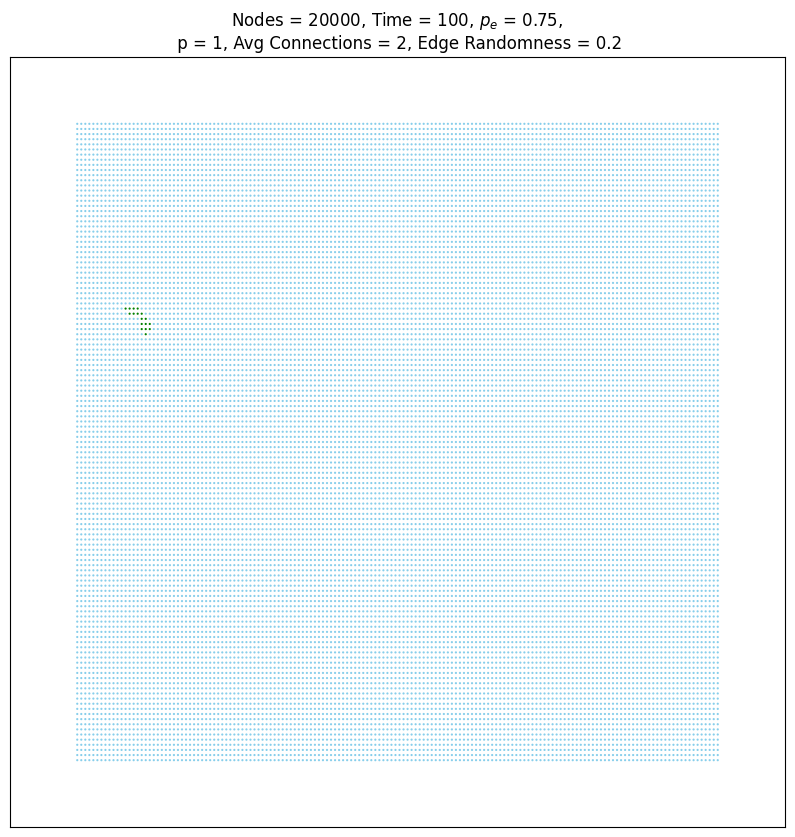

In [179]:
G = Pandemic_Network(p_edge_removal= 0.75, nodes = 20000, network_type='NA',pandemicprob=1, reduced_prob= 0.1, mitigation_proportion=0.0, sicknode = 1).propagate(100)

## Bond Percolation Analysis

In [11]:
param_vals = [i/20 for i in range(1,20)]
cumulative_data = []
infectious_data = []
for i in param_vals:
    repeats_c = []
    repeats_i = []
    for j in range(20): # 20 runs for each value of parameter
        G = Pandemic_Network(nodes = 10000, network_type='Small World', pandemicprob = i, sicknode = 1, SW_connections = 3, edge_randomness = 0.2, reduced_prob = 0.1, mitigation_proportion = 0, plots = False).propagate(1000)
        repeats_c.append(G[-1])
        repeats_i.append(G[1])
    cumulative_data.append(repeats_c)
    infectious_data.append(repeats_i)

100%|██████████| 1000/1000 [00:13<00:00, 73.82it/s]


In [15]:
df_c = pd.DataFrame(data = [i for i in cumulative_data]).transpose()
df_c.columns = param_vals
df_c.to_csv('Cumulative Data, multiple runs, varying probability of infection - {}.csv'. format(date))

df_i = pd.DataFrame(data = [i for i in infectious_data]).transpose()
df_i.columns = param_vals
df_i.to_csv('Infectious Data, multiple runs, varying probability of infection - {}.csv'. format(date))


In [14]:
date = datetime.date.today()

In [34]:
for i in cumulative_data:
    df = pd.DataFrame(data = [i for i in cumulative_data]).transpose()
    print(len(i))

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


In [39]:
df = pd.DataFrame(data = [i for i in cumulative_data]).transpose()
df.columns = param_vals
df.to_csv('Bond Percolation Data, multiple runs, varying probability of infection - {}.csv'. format(date))
df

,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
0,"[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, ...","[1, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, ...","[1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 6, 6, 7, 8, ...","[1, 1, 1, 1, 2, 2, 4, 4, 6, 8, 9, 10, 10, 12, ...","[1, 2, 2, 3, 3, 4, 5, 5, 6, 7, 7, 8, 9, 9, 10,...","[1, 1, 1, 3, 3, 4, 4, 4, 4, 5, 6, 8, 8, 9, 9, ...","[1, 2, 4, 5, 5, 5, 5, 6, 8, 10, 11, 12, 13, 13...","[1, 1, 2, 4, 6, 7, 8, 9, 12, 14, 17, 20, 23, 2...","[1, 2, 3, 5, 7, 9, 11, 14, 15, 19, 22, 25, 25,...","[1, 1, 2, 4, 6, 8, 10, 11, 14, 16, 19, 22, 25,...","[1, 3, 5, 9, 11, 12, 15, 19, 23, 24, 27, 30, 3...","[1, 2, 4, 6, 7, 9, 11, 12, 14, 17, 20, 23, 26,...","[1, 2, 3, 5, 7, 8, 9, 12, 14, 16, 18, 21, 23, ...","[1, 2, 3, 3, 3, 4, 5, 6, 7, 8, 9, 11, 13, 13, ...","[1, 2, 4, 6, 7, 9, 10, 12, 14, 16, 18, 19, 19,...","[1, 3, 4, 6, 7, 9, 10, 11, 12, 13, 15, 18, 23,...","[1, 2, 3, 3, 4, 5, 6, 7, 9, 11, 13, 15, 18, 23...","[1, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 13, 14, 16..."
1,"[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 4, 4, 5, 6, 6, ...","[1, 2, 4, 5, 5, 6, 6, 7, 8, 8, 11, 11, 11, 11,...","[1, 1, 1, 2, 3, 4, 4, 5, 5, 5, 5, 6, 7, 8, 8, ...","[1, 2, 2, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, 7, ...","[1, 2, 4, 6, 6, 6, 7, 9, 10, 11, 15, 16, 18, 2...","[1, 2, 3, 5, 6, 6, 7, 7, 8, 9, 9, 9, 10, 11, 1...","[1, 2, 2, 3, 4, 6, 6, 7, 7, 10, 10, 11, 11, 12...","[1, 2, 4, 5, 6, 7, 7, 8, 9, 9, 11, 13, 17, 20,...","[1, 3, 4, 5, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11,...","[1, 4, 7, 11, 16, 24, 34, 41, 50, 58, 63, 73, ...","[1, 1, 2, 4, 6, 8, 10, 12, 12, 15, 17, 19, 20,...","[1, 2, 4, 5, 6, 7, 7, 9, 10, 11, 12, 15, 16, 1...","[1, 2, 4, 7, 9, 11, 15, 17, 20, 27, 32, 37, 39...","[1, 2, 3, 4, 6, 8, 9, 10, 11, 11, 12, 13, 14, ...","[1, 3, 5, 8, 11, 14, 19, 23, 28, 32, 34, 37, 4...","[1, 2, 4, 5, 7, 9, 12, 16, 21, 29, 34, 38, 40,...","[1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 19, 21, 24..."
2,"[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, ...","[1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 5, 6, 6, 8, 9, ...","[1, 1, 3, 4, 4, 4, 5, 6, 7, 7, 8, 9, 9, 9, 10,...","[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, ...","[1, 2, 4, 4, 4, 4, 5, 5, 6, 7, 7, 8, 10, 10, 1...","[1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 6, 8, 8, 10, 13...","[1, 2, 3, 7, 10, 13, 16, 19, 21, 23, 27, 29, 3...","[1, 2, 4, 6, 7, 8, 11, 13, 15, 17, 20, 24, 27,...","[1, 2, 4, 5, 6, 8, 11, 11, 13, 13, 14, 14, 15,...","[1, 2, 3, 4, 6, 8, 11, 15, 16, 18, 21, 24, 27,...","[1, 1, 3, 4, 4, 5, 5, 5, 6, 6, 7, 8, 8, 10, 12...","[1, 3, 4, 7, 10, 12, 16, 19, 20, 21, 22, 22, 2...","[1, 3, 5, 6, 9, 11, 15, 17, 19, 20, 22, 23, 24...","[1, 3, 5, 6, 7, 8, 9, 10, 13, 17, 21, 25, 28, ...","[1, 3, 3, 4, 5, 6, 7, 8, 11, 13, 15, 18, 22, 2...","[1, 3, 6, 10, 17, 23, 28, 32, 35, 37, 40, 42, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 4, 5, 5, 5, 6, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, ...","[1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 6, 6, ...","[1, 2, 3, 3, 3, 3, 3, 4, 4, 6, 6, 6, 6, 6, 6, ...","[1, 1, 2, 3, 4, 6, 8, 11, 13, 18, 21, 24, 27, ...","[1, 2, 4, 4, 5, 6, 6, 7, 7, 7, 8, 8, 9, 10, 10...","[1, 2, 3, 3, 4, 4, 6, 7, 7, 7, 8, 9, 9, 9, 10,...","[1, 3, 4, 5, 6, 8, 12, 13, 15, 17, 18, 21, 24,...","[1, 1, 1, 3, 4, 5, 6, 6, 7, 7, 8, 11, 11, 12, ...","[1, 2, 2, 4, 6, 7, 9, 10, 13, 16, 17, 21, 23, ...","[1, 2, 2, 3, 4, 4, 4, 5, 7, 9, 11, 12, 15, 19,...","[1, 1, 2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 10, 12...","[1, 1, 3, 5, 7, 8, 12, 16, 20, 23, 27, 30, 34,...","[1, 2, 4, 7, 9, 11, 13, 16, 20, 25, 27, 32, 36...","[1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11,...","[1, 3, 4, 8, 12, 17, 22, 29, 36, 40, 43, 45, 4...","[1, 3, 6, 9, 13, 15, 18, 20, 23, 27, 32, 36, 4...","[1, 3, 6, 11, 17, 22, 27, 31, 35, 37, 41, 45, .

In [29]:
df = pd.DataFrame(data = [i for i in cumulative_data]).transpose()
df.columns = [str(i) for i in param_vals]

date = datetime.date.today()
df.to_csv('Bond Percolation Data, varying probability of infection - {}.csv'. format(date))
df

,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,2,2,3,2,2,2,2,3,2,3,3,3,2,2,2
2,1,1,1,1,3,3,3,3,2,3,4,5,4,3,5,4,3,4,4
3,1,2,1,1,3,4,4,5,3,4,6,6,6,3,7,7,4,6,6
4,2,2,1,2,3,4,6,7,3,5,9,8,10,4,8,8,7,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,8,30,7,245,12351,13328,54896,53325,78229,21893,37034,24578,45413,86795,47316,37476,98251,38117
996,2,8,30,7,245,12372,13342,54958,53442,78313,21906,37103,24583,45520,86824,47442,37481,98272,38117
997,2,8,30,7,245,12394,13356,55024,53569,78377,21926,37181,24587,45620,86861,47570,37487,98289,38117
998,2,8,30,7,245,12420,13369,55081,53692,78445,21940,37259,24591,45719,86903,47698,37491,98308,38117


# Average Path Length Investigation

In [62]:
nodes = 500
con = 3
p_rand = 0.5

probability = 0.5

p_values = [i/10 for i in range(1,10)] # varying the number of individuals adopting mitigation measure
connections = [2,3,4,5]


results = []
for p in p_values:
    c_list = []
    for c in connections:
        print('Proportion = ', p, 'Connections = ', c)

        g = nx.watts_strogatz_graph(n = nodes, k = c, p = p_rand, seed= 1)

        # nx.draw_networkx(g, pos = nx.circular_layout(g), with_labels=False, node_size=30, linewidths=1, width = 1)

        ASPL_w = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_w.append(nx.average_shortest_path_length(C))
        print('Without weighting: ', statistics.mean(ASPL_w))

        nodes_list = list(g.edges)

        adjusted = [0.5 if random.random()<p else 1 for i in range(len(list(g.edges)))]

        print('Actual proportion of weighted edges: ', adjusted.count(0.5)/len(adjusted))

        weight_dict = {nodes_list[i]:1/adjusted[i] for i in range(len(nodes_list))}
        nx.set_edge_attributes(g, weight_dict, name = 'weight')
    
        ASPL_wo = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_wo.append(nx.average_shortest_path_length(C, weight = 'weight'))
        print('With weighting: ', statistics.mean(ASPL_wo))
        c_list.append([statistics.mean(ASPL_w), statistics.mean(ASPL_wo)])
    results.append(c_list)


Proportion =  0.1 Connections =  2
Without weighting:  27.564945891783566
Actual proportion of weighted edges:  0.112
With weighting:  30.20879358717435
Proportion =  0.1 Connections =  3
Without weighting:  27.564945891783566
Actual proportion of weighted edges:  0.094
With weighting:  29.736585170340682
Proportion =  0.1 Connections =  4
Without weighting:  5.005218436873747
Actual proportion of weighted edges:  0.082
With weighting:  5.238180360721443
Proportion =  0.1 Connections =  5
Without weighting:  5.005218436873747
Actual proportion of weighted edges:  0.114
With weighting:  5.3607134268537076
Proportion =  0.2 Connections =  2
Without weighting:  27.564945891783566
Actual proportion of weighted edges:  0.216
With weighting:  34.038573146292585
Proportion =  0.2 Connections =  3
Without weighting:  27.564945891783566
Actual proportion of weighted edges:  0.186
With weighting:  32.03728256513026
Proportion =  0.2 Connections =  4
Without weighting:  5.005218436873747
Actual p

In [1]:
df = pd.DataFrame(data = [i for i in results])
df.columns = connections
df['Proportion of Population Adopting Mitigation'] = p_values

NameError: name 'pd' is not defined

In [76]:
date = datetime.date.today()
df.to_csv('Average Path Length Data for varying probabilities and average number of connections - {}.csv'. format(date))

## Consider the case for a 100% effective mitigation measure

In [7]:
nodes = 5000

p_values = [i/10 for i in range(1,10)] # varying the number of individuals adopting mitigation measure
connections = [2,3,4,5]

results = []
for p in p_values:
    c_list = []
    for c in connections:
        print('Proportion = ', p, 'Connections = ', c)

        g = nx.watts_strogatz_graph(n = nodes, k = c, p = 0.5, seed= 1)
        # nx.draw_networkx(g, pos = nx.circular_layout(g), with_labels=False, node_size=30, linewidths=1, width = 1)

        ASPL_w = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_w.append(nx.average_shortest_path_length(C))
        print('Without weighting: ', statistics.mean(ASPL_w))

        nodes_list = list(g.edges)

        adjusted = [0.01 if random.random()<p else 1 for i in range(len(list(g.edges)))]

        actual_adoption = adjusted.count(0.01)/len(adjusted)

        print('Actual proportion of weighted edges: ', actual_adoption)

        weight_dict = {nodes_list[i]:1/adjusted[i] for i in range(len(nodes_list))}
        nx.set_edge_attributes(g, weight_dict, name = 'weight')
    
        ASPL_wo = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_wo.append(nx.average_shortest_path_length(C, weight = 'weight'))
        print('With weighting: ', statistics.mean(ASPL_wo))
        c_list.append([actual_adoption, statistics.mean(ASPL_w), statistics.mean(ASPL_wo)])
    results.append(c_list)

Proportion =  0.1 Connections =  2
Without weighting:  42.57297278922878
Actual proportion of weighted edges:  0.1
With weighting:  497.792981563025
Proportion =  0.1 Connections =  3
Without weighting:  42.57297278922878
Actual proportion of weighted edges:  0.1018
With weighting:  468.89067038421103
Proportion =  0.1 Connections =  4
Without weighting:  6.9984375275055015
Actual proportion of weighted edges:  0.1021
With weighting:  8.005214962992598
Proportion =  0.1 Connections =  5
Without weighting:  6.9984375275055015
Actual proportion of weighted edges:  0.0973
With weighting:  7.755232646529306
Proportion =  0.2 Connections =  2
Without weighting:  42.57297278922878
Actual proportion of weighted edges:  0.2024
With weighting:  839.8452250694148
Proportion =  0.2 Connections =  3
Without weighting:  42.57297278922878
Actual proportion of weighted edges:  0.1984
With weighting:  784.8725460410559
Proportion =  0.2 Connections =  4
Without weighting:  6.9984375275055015
Actual pr

In [12]:
nodes = 5000

p_values = [i/10 for i in range(1,10)] # varying the number of individuals adopting mitigation measure
connections = [6, 7]

add_results = []
for p in p_values:
    c_list = []
    for c in connections:
        print('Proportion = ', p, 'Connections = ', c)

        g = nx.watts_strogatz_graph(n = nodes, k = c, p = 0.5, seed= 1)
        # nx.draw_networkx(g, pos = nx.circular_layout(g), with_labels=False, node_size=30, linewidths=1, width = 1)

        ASPL_w = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_w.append(nx.average_shortest_path_length(C))
        print('Without weighting: ', statistics.mean(ASPL_w))

        nodes_list = list(g.edges)

        adjusted = [0.01 if random.random()<p else 1 for i in range(len(list(g.edges)))]

        actual_adoption = adjusted.count(0.01)/len(adjusted)

        print('Actual proportion of weighted edges: ', actual_adoption)

        weight_dict = {nodes_list[i]:1/adjusted[i] for i in range(len(nodes_list))}
        nx.set_edge_attributes(g, weight_dict, name = 'weight')
    
        ASPL_wo = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_wo.append(nx.average_shortest_path_length(C, weight = 'weight'))
        print('With weighting: ', statistics.mean(ASPL_wo))
        c_list.append([actual_adoption, statistics.mean(ASPL_w), statistics.mean(ASPL_wo)])
    add_results.append(c_list)

Proportion =  0.1 Connections =  6
Without weighting:  5.283807081416283
Actual proportion of weighted edges:  0.1024
With weighting:  5.609565913182636
Proportion =  0.1 Connections =  7
Without weighting:  5.283807081416283
Actual proportion of weighted edges:  0.0966
With weighting:  5.587832686537308
Proportion =  0.2 Connections =  6
Without weighting:  5.283807081416283
Actual proportion of weighted edges:  0.19606666666666667
With weighting:  6.079012682536507
Proportion =  0.2 Connections =  7
Without weighting:  5.283807081416283
Actual proportion of weighted edges:  0.20733333333333334
With weighting:  6.174574834966993
Proportion =  0.3 Connections =  6
Without weighting:  5.283807081416283
Actual proportion of weighted edges:  0.298
With weighting:  7.1920875375075015
Proportion =  0.3 Connections =  7
Without weighting:  5.283807081416283
Actual proportion of weighted edges:  0.2992
With weighting:  7.115824764952991
Proportion =  0.4 Connections =  6
Without weighting:  5

In [15]:
results.append(add_results)

In [38]:
con_6 = []
con_7 = []
for j in range(len(add_results)):
    print(add_results[j])

    con_6.append(add_results[j][0])
    con_7.append(add_results[j][1])

[[0.1024, 5.283807081416283, 5.609565913182636], [0.0966, 5.283807081416283, 5.587832686537308]]
[[0.19606666666666667, 5.283807081416283, 6.079012682536507], [0.20733333333333334, 5.283807081416283, 6.174574834966993]]
[[0.298, 5.283807081416283, 7.1920875375075015], [0.2992, 5.283807081416283, 7.115824764952991]]
[[0.4020666666666667, 5.283807081416283, 9.27577699539908], [0.3998, 5.283807081416283, 9.543535667133426]]
[[0.49846666666666667, 5.283807081416283, 14.089098539707942], [0.507, 5.283807081416283, 15.424815523104622]]
[[0.5976666666666667, 5.283807081416283, 29.223664412882577], [0.6039333333333333, 5.283807081416283, 30.905827645529104]]
[[0.6970666666666666, 5.283807081416283, 65.77254450890177], [0.6938, 5.283807081416283, 62.04264428885777]]
[[0.8032, 5.283807081416283, 238.8223696739348], [0.7977333333333333, 5.283807081416283, 216.480125385077]]
[[0.8993333333333333, 5.283807081416283, 385.293200480096], [0.8999333333333334, 5.283807081416283, 395.58194510902183]]


In [51]:
date = datetime.date.today()
df.to_csv('Average Path Length Data for varying probabilities and average number of connections, effective mitigation (updates) - {}.csv'. format(date))

In [ ]:
nodes = 5000

p_values = [i/10 for i in range(1,10)] # varying the number of individuals adopting mitigation measure
connections = [6, 7]

add_results = []
for p in p_values:
    c_list = []
    for c in connections:
        print('Proportion = ', p, 'Connections = ', c)

        g = nx.watts_strogatz_graph(n = nodes, k = c, p = 0.5, seed= 1)
        # nx.draw_networkx(g, pos = nx.circular_layout(g), with_labels=False, node_size=30, linewidths=1, width = 1)

        ASPL_w = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_w.append(nx.average_shortest_path_length(C))
        print('Without weighting: ', statistics.mean(ASPL_w))

        nodes_list = list(g.edges)

        adjusted = [0.01 if random.random()<p else 1 for i in range(len(list(g.edges)))]

        actual_adoption = adjusted.count(0.01)/len(adjusted)

        print('Actual proportion of weighted edges: ', actual_adoption)

        weight_dict = {nodes_list[i]:1/adjusted[i] for i in range(len(nodes_list))}
        nx.set_edge_attributes(g, weight_dict, name = 'weight')
    
        ASPL_wo = []
        for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
            ASPL_wo.append(nx.average_shortest_path_length(C, weight = 'weight'))
        print('With weighting: ', statistics.mean(ASPL_wo))
        c_list.append([actual_adoption, statistics.mean(ASPL_w), statistics.mean(ASPL_wo)])
    add_results.append(c_list)

# Updated for ASPL investigation

In [84]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, reduced_prob: float ,mitigation_proportion: float, sicknode = 0, SW_connections = 3, edge_randomness = 0.2, SF_k = 1, plots = False, aspl = False, TTR = 15):
        '''
        sicknodes - number of sick nodes to begin with
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = edge_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = edge_randomness, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        # self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.p_reduced = reduced_prob # reduced probability of infection due to mitigation
        self.mit_prop = mitigation_proportion # proporation of the population that follows the mitigation
        self.want_plots = plots
        self.want_aspl = aspl
        self.masked = []
        self.sicknodes = [random.randint(0, nodes-1) for i in range(sicknode)] # randomly generate n number of sicknnodes
        # print(self.sicknodes)
        # if not sicknode:
        #     self.sicknodes = set([])
        # else:
        #     self.sicknodes = set([sicknode])
        self.recovered = []
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model

        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
    
    def plot(self):

        node_colors = ["green" if node in self.recovered else 'magenta' if node in self.masked else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p_reduced]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible

        plt.title("Small Worlds Graph: Nodes = "+ str(self.n)+ ", Time = " + str(self.t))
        plt.show()
        return
    
    def ASPL(self):
        ASPL_w = []
        for C in (self.g.subgraph(c).copy() for c in nx.connected_components(self.g)):
            ASPL_w.append(nx.average_shortest_path_length(C, weight= 'weight'))
        return statistics.mean(ASPL_w)

    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []
        aspl_count = []

        for time in tqdm.tqdm(range(steps)):
            #check sick nodes
            new_sick = 0
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                cumulative_case_count.append(len(self.sicknodes))

                # initialise edge weights
                for i in self.sicknodes:
                    if np.random.random() < self.mit_prop: # a proportion of initially sick nodes will adopt mitigation measures
                        self.masked.append(i)
                    else: 
                        pass
                edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                for j in edge_list:
                    if (j[0] in self.masked or j[1] in self.masked)  :
                        self.g.add_edge(j[0], j[1], weight = 1/self.p_reduced) 
                    elif (j[0] in self.sicknodes or j[1] in self.sicknodes) and (j[0] not in self.masked or j[1] not in self.masked):
                        self.g.add_edge(j[0], j[1], weight = 1/self.p) 
                    else:
                        self.g.add_edge(j[0], j[1], weight = 0) 

                # self.plot()
                
            else: 
                pass
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            
            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones
            #print("sicknodes:", currentsick)

            for i in range(len(list(self.g.nodes))):
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    neighbours = list(self.g.neighbors(i))
                    for n in neighbours:
                        if n in self.sicknodes:
                            pass
                        else:
                            self.g.add_edge(i, n, weight = 1/self.p_reduced) # once recovered, cannot be reinfected again, therefore all the edges should have a weighting of 0.

                    if i in self.masked:
                        self.masked.remove(i)
                    else:
                        pass
                    self.recovered.append(i)
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
            
            for node in currentsick:
                neighbours = list(self.g.neighbors(node))

                #try to propagate sickness
                for neighbour in neighbours:
                    if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick or recovered.
                        pass
                    elif self.g.get_edge_data(node,neighbour)['weight'] != 0 and np.random.random() < (1/self.g.get_edge_data(node,neighbour)['weight']): # new node infected
                        self.sicknodes.append(neighbour)
                        adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                        new_sick += 1

                        nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                        if np.random.random() < self.mit_prop: # determine whether newly sick node will adopt mitigation measure
                            self.masked.append(neighbour)
                            for i in adj_neighbours:
                                self.g.add_edge(i, neighbour, weight = 1/self.p_reduced) # mitigated probability of infection -> overwrite all edges

                        else: # node did not adopt mitigation measure 
                            for i in adj_neighbours: 
                                if self.g.get_edge_data(i,neighbour)['weight'] == 1/self.p_reduced: # do not overwrite mitigated edges
                                    pass
                                else: 
                                    self.g.add_edge(i, neighbour, weight = 1/self.p) # non-mitigated probability of infection.

                    else: # node not infected
                        pass
            
            cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
            
            if self.want_aspl:
                aspl_count.append(self.ASPL())
        
        if self.want_aspl:
            return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], aspl_count
        else:    
            # self.plot()             
            return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1]

In [56]:
m_values = [i/10 for i in range(1,10)]
connections = [5, 6]

results = []
for m in m_values:
    c_list = []
    for c in connections:
        G = Pandemic_Network(nodes = 500, network_type='Small World', pandemicprob = 1, sicknode = 1, SW_connections = c, edge_randomness = 0.2, 
                             reduced_prob = 0.01, mitigation_proportion = m, plots = False, aspl = True)
        data = G.propagate(300)
        c_list.append([data[1], data[-2], data[-1]]) # infectious, cumulative, ASPL
    results.append(c_list)


 35%|███▍      | 104/300 [03:31<06:37,  2.03s/it]


KeyboardInterrupt: 

In [54]:
df = pd.DataFrame(results)
df.columns = connections

df

,2,3,4
0,"[[1, 3, 5, 7, 10, 14, 16, 18, 20, 22, 24, 24, ...","[[1, 3, 5, 6, 7, 9, 11, 12, 13, 14, 16, 19, 22...","[[1, 5, 15, 33, 70, 146, 258, 387, 467, 494, 4..."
1,"[[1, 3, 5, 8, 12, 16, 19, 21, 24, 25, 26, 28, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 5, 11, 26, 63, 125, 227, 351, 447, 487, 4..."
2,"[[1, 3, 6, 9, 11, 12, 14, 16, 17, 17, 17, 17, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 5, 7, 10, 14, 19, 24, 29, 44, 70, 124, 20..."
3,"[[1, 3, 6, 8, 11, 12, 13, 14, 15, 18, 23, 28, ...","[[1, 3, 6, 9, 10, 10, 10, 10, 10, 10, 10, 10, ...","[[1, 4, 8, 11, 20, 29, 50, 75, 107, 137, 178, ..."
4,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 6, 10, 17, 27, 37, 55, 74, 91, 110, 136, ..."
5,"[[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
6,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
7,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...","[[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
8,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,...","[[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [55]:
date = datetime.date.today()
df.to_csv('ASPL and Propagation Time - {}.csv'. format(date))

In [108]:
G = Pandemic_Network(nodes = 1000, network_type='Small World', pandemicprob = 1, sicknode = 1, SW_connections = 3, edge_randomness = 0.2, 
                             reduced_prob = 0.5, mitigation_proportion = 0.1, plots = False, aspl = True)
data = G.propagate(300)

  0%|          | 0/300 [00:00<?, ?it/s]100%|██████████| 300/300 [10:14<00:00,  2.05s/it]


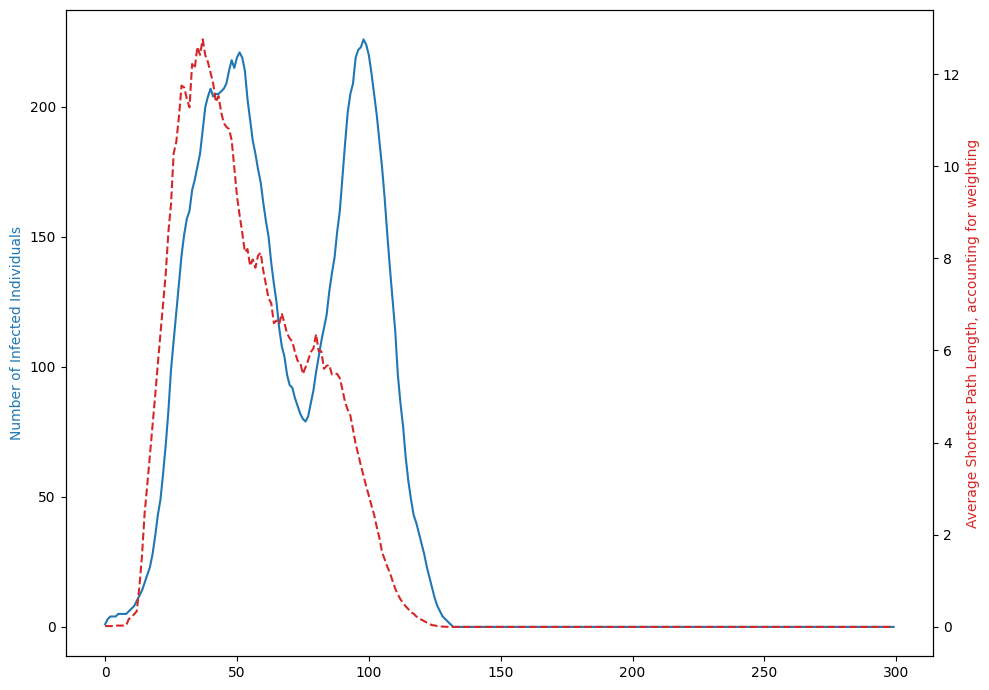

In [110]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax2 = ax1.twinx()

ax1.plot(data[0],data[1], '-', color = 'tab:blue', label = 'Infectious')
ax1.set_ylabel('Number of Infected Individuals', color = 'tab:blue')

ax2.plot(data[0],data[-1], '--',color = 'tab:red', label = 'ASPL')
ax2.set_ylabel('Average Shortest Path Length, accounting for weighting', color = 'tab:red')
# fig.legend()
plt.xlabel('Time / Days')
plt.tight_layout()
plt.show()

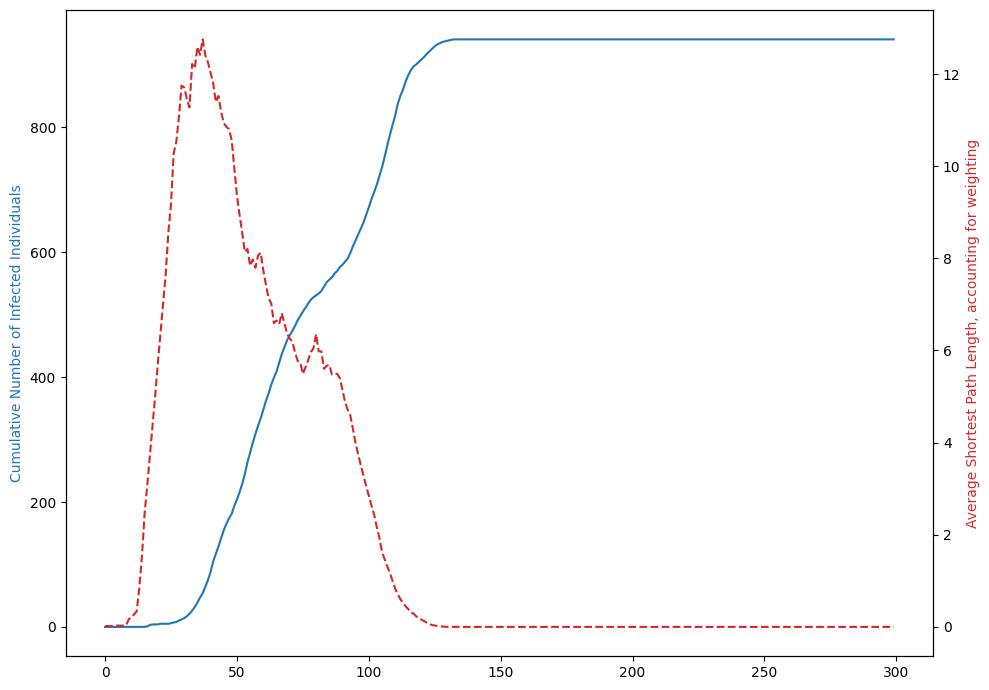

In [114]:
# norm_aspl = [i/max(data[-1]) for i in data[-1]]

fig, ax1 = plt.subplots(figsize = (10,7))
ax2 = ax1.twinx()

ax1.plot(data[0],data[2], '-', color = 'tab:blue', label = 'Infectious')
ax1.set_ylabel('Cumulative Number of Infected Individuals', color = 'tab:blue')

ax2.plot(data[0],data[-1], '--',color = 'tab:red', label = 'ASPL')
ax2.set_ylabel('Average Shortest Path Length, accounting for weighting', color = 'tab:red')
# fig.legend()
plt.xlabel('Time / Days')
plt.tight_layout()
plt.show()

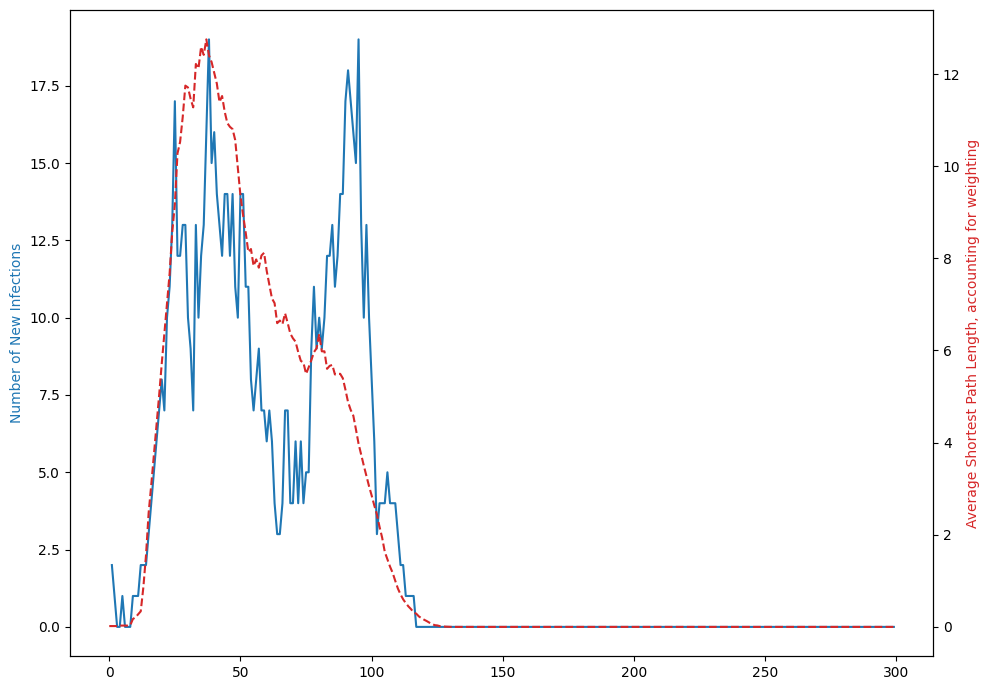

In [112]:
rate = [data[-2][i] - data[-2][i-1] for i in range(1, len(data[-2]))]

fig, ax1 = plt.subplots(figsize = (10,7))
ax2 = ax1.twinx()

ax1.plot(data[0][1:], rate, '-', color = 'tab:blue', label = 'Infectious')
ax1.set_ylabel('Number of New Infections', color = 'tab:blue')

ax2.plot(data[0],data[-1], '--',color = 'tab:red', label = 'ASPL')
ax2.set_ylabel('Average Shortest Path Length, accounting for weighting', color = 'tab:red')
# fig.legend()
plt.xlabel('Time / Days')
plt.tight_layout()
plt.show()


In [23]:
cons = [2, 3, 4, 5, 6, 7]
mprob = [i/10 for i in range(1,10)]
timesteps = 1000

results = []
for c in cons:
    prop_time = []
    for m in mprob:
        dummy = []
        for k in range(20):
            G = Pandemic_Network(nodes = 5000, network_type='Small World', pandemicprob = 1, sicknode = 1, SW_connections = c, edge_randomness = 0.2, 
                                reduced_prob = 0.01, mitigation_proportion = m, plots = False, aspl = False)
            data = G.propagate(timesteps)
            dummy.append(timesteps - data[-1].count(max(data[-1])))
        prop_time.append(statistics.mean(dummy))
    results.append(prop_time)


  9%|▊         | 87/1000 [00:00<00:07, 128.46it/s]


KeyboardInterrupt: 

In [22]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, reduced_prob: float ,mitigation_proportion: float, sicknode = 0, SW_connections = 3, edge_randomness = 0.2, SF_k = 1, plots = False, aspl = False, TTR = 15):
        '''
        sicknodes - number of sick nodes to begin with
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = edge_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = edge_randomness, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        # self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.p_reduced = reduced_prob # reduced probability of infection due to mitigation
        self.mit_prop = mitigation_proportion # proporation of the population that follows the mitigation
        self.want_plots = plots
        self.want_aspl = aspl
        self.masked = []
        self.sicknodes = [random.randint(0, nodes-1) for i in range(sicknode)] # randomly generate n number of sicknnodes
        # print(self.sicknodes)
        # if not sicknode:
        #     self.sicknodes = set([])
        # else:
        #     self.sicknodes = set([sicknode])
        self.recovered = []
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model

        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
    
    def plot(self):

        node_colors = ["green" if node in self.recovered else 'magenta' if node in self.masked else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p_reduced]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible

        plt.title("Small Worlds Graph: Nodes = "+ str(self.n)+ ", Time = " + str(self.t))
        plt.show()
        return
    
    def ASPL(self):
        ASPL_w = []
        for C in (self.g.subgraph(c).copy() for c in nx.connected_components(self.g)):
            ASPL_w.append(nx.average_shortest_path_length(C, weight= 'weight'))
        return statistics.mean(ASPL_w)

    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []
        aspl_count = []

        for time in tqdm.tqdm(range(steps)):
            #check sick nodes
            new_sick = 0
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                cumulative_case_count.append(len(self.sicknodes))

                # initialise edge weights
                for i in self.sicknodes:
                    if np.random.random() < self.mit_prop: # a proportion of initially sick nodes will adopt mitigation measures
                        self.masked.append(i)
                    else: 
                        pass
                edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                for j in edge_list:
                    if (j[0] in self.masked or j[1] in self.masked)  :
                        self.g.add_edge(j[0], j[1], weight = 1/self.p_reduced) 
                    elif (j[0] in self.sicknodes or j[1] in self.sicknodes) and (j[0] not in self.masked or j[1] not in self.masked):
                        self.g.add_edge(j[0], j[1], weight = 1/self.p) 
                    else:
                        self.g.add_edge(j[0], j[1], weight = 0) 

                # self.plot()
                
            else: 
                pass
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            
            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones
            #print("sicknodes:", currentsick)

            for i in range(len(list(self.g.nodes))):
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    neighbours = list(self.g.neighbors(i))
                    for n in neighbours:
                        if n in self.sicknodes:
                            pass
                        else:
                            self.g.add_edge(i, n, weight = 1/self.p_reduced) # once recovered, cannot be reinfected again, therefore all the edges should have a weighting of 0.

                    if i in self.masked:
                        self.masked.remove(i)
                    else:
                        pass
                    self.recovered.append(i)
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
            
            for node in currentsick:
                neighbours = list(self.g.neighbors(node))

                #try to propagate sickness
                for neighbour in neighbours:
                    if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick or recovered.
                        pass
                    elif self.g.get_edge_data(node,neighbour)['weight'] != 0 and np.random.random() < (1/self.g.get_edge_data(node,neighbour)['weight']): # new node infected
                        self.sicknodes.append(neighbour)
                        adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                        new_sick += 1

                        nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                        if np.random.random() < self.mit_prop: # determine whether newly sick node will adopt mitigation measure
                            self.masked.append(neighbour)
                            for i in adj_neighbours:
                                self.g.add_edge(i, neighbour, weight = 1/self.p_reduced) # mitigated probability of infection -> overwrite all edges

                        else: # node did not adopt mitigation measure 
                            for i in adj_neighbours: 
                                if self.g.get_edge_data(i,neighbour)['weight'] == 1/self.p_reduced: # do not overwrite mitigated edges
                                    pass
                                else: 
                                    self.g.add_edge(i, neighbour, weight = 1/self.p) # non-mitigated probability of infection.

                    else: # node not infected
                        pass
            
            cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
            
            if self.want_aspl:
                aspl_count.append(self.ASPL())
        
        if self.want_aspl:
            return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], aspl_count
        else:    
            # self.plot()             
            return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1]

In [7]:
nodes = 5000

g_1 = nx.watts_strogatz_graph(n = nodes, k = 4, p = 0, seed=None)
print(len(list(g_1.edges)))

g_2 = nx.barabasi_albert_graph(n = nodes, m = 2, seed=None, initial_graph=None)
print(len(list(g_2.edges)))


10000
9996


In [8]:
print(nx.average_shortest_path_length(g_1))
print(nx.average_shortest_path_length(g_2))

625.375075015003
4.7471121424284854
